In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np

import torch
import os
from tqdm import tqdm

from iopath.common.file_io import PathManager
from iopath.fb.manifold import ManifoldPathHandler

sys.path.insert(0, "fbcode/ar_sharing/body_tracking_3d/models/hmr/")

pathmgr = PathManager()
pathmgr.register_handler(ManifoldPathHandler(), allow_override=True)

%load_ext autoreload
%autoreload 2

from skimage.util.shape import view_as_windows

I1007 064250.257 _utils_internal.py:179] NCCL_DEBUG env var is set to None


I1007 064250.258 _utils_internal.py:188] NCCL_DEBUG is INFO from /etc/nccl.conf


I1007 064251.203 parsh_logger.py:29] %autoreload 2 was called with 


In [2]:
import src

In [3]:
device = "cuda:0"
torch.set_grad_enabled(False)

### add tcmr path
sys.path.insert(0, "fbcode/ar_sharing/body_tracking_3d/models/tcmr/TCMR_RELEASE/")
from lib.models.tcmr import TCMR

from lib.utils.eval_utils import compute_accel, compute_error_accel, batch_compute_similarity_transform_torch, compute_error_verts
from collections import defaultdict
from copy import deepcopy

In [4]:
def split_into_chunks(vid_names, seqlen, stride, is_train=True, match_vibe=True):
    video_start_end_indices = []
    video_names, group = np.unique(vid_names, return_index=True)
    perm = np.argsort(group)
    video_names, group = video_names[perm], group[perm]

    indices = np.split(np.arange(0, vid_names.shape[0]), group[1:])
    # import pdb; pdb.set_trace()
    for idx in range(len(video_names)):
        indexes = indices[idx]
        if indexes.shape[0] < seqlen:
            continue
        chunks = view_as_windows(indexes, (seqlen,), step=stride)
        start_finish = chunks[:, (0, -1)].tolist()
        if stride != seqlen:
            if match_vibe:
                vibe_chunks = view_as_windows(indexes, (16,), step=16)
                for j in range(1,len(start_finish)+1):
                    if start_finish[-j][-1] == vibe_chunks[-1][-1]:
                        if j != 1:
                            start_finish = start_finish[:-j+1]
                        break

            d = start_finish[0][0]
            for j in range(int(seqlen/2)):
                if is_train:
                    dummy = start_finish[0]
                else:
                    dummy = [d+j, d+j]
                start_finish.insert(j,dummy)
            d = start_finish[-1][0]
            for j in range(int(seqlen/2+0.5)-1):
                if is_train:
                    dummy = start_finish[-1]
                else:
                    dummy = [d+int(seqlen/2)+j+1, d+int(seqlen/2)+j+1]
                start_finish.append(dummy)
        video_start_end_indices += start_finish

    return video_start_end_indices

def get_sequence(start_index, end_index, seqlen=16):
    if start_index != end_index:
        return [i for i in range(start_index, end_index+1)]
    else:
        return [start_index for _ in range(seqlen)]

# based on 
## https://github.com/hongsukchoi/TCMR_RELEASE/blob/master/evaluate.py

In [5]:
j_regr = pathmgr.get_local_path(
    "manifold://xr_body/tree/personal/andreydavydov/eft/extradata/data_from_spin/J_regressor_h36m.npy"
)
J_regressor = torch.from_numpy(np.load(j_regr)).float()

TCMR_BASE_DIR = "manifold://xr_body/tree/personal/andreydavydov/tcmr"
TCMR_TABLE4_FILE = "tcmr_table4_3dpw_test.pth.tar"

I1007 064307.165 manifold.py:1442] URL manifold://xr_body/tree/personal/andreydavydov/eft/extradata/data_from_spin/J_regressor_h36m.npy was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/eft/extradata/data_from_spin/J_regressor_h36m.npy


In [19]:
seqlens = list(range(4, 33, 4))
print(seqlens)
results = {}

for seqlen in seqlens:
    model = TCMR(
        n_layers=2,
        batch_size=32,
        seqlen=seqlen,
        hidden_size=1024,
    ).to(device)

    checkpoint = torch.load(pathmgr.get_local_path(os.path.join(TCMR_BASE_DIR, TCMR_TABLE4_FILE)))
    model.load_state_dict(checkpoint["gen_state_dict"])
    print(f"==> Loaded pretrained model from {os.path.join(TCMR_BASE_DIR, TCMR_TABLE4_FILE)}...")

    ### prepare 3dpw test set
    from src.datasets.threedpw import ThreeDPW

    dataset = ThreeDPW(set="test", seqlen=seqlen, debug=True)
    batch_size = 16
    dataload = torch.utils.data.DataLoader(dataset, shuffle=False, batch_size=batch_size, num_workers=8)

    ### prepare dataset dict (features presaved)
    dataset_data = dataset.db
    vid_name_list = dataset_data["vid_name"]
    unique_names = np.unique(vid_name_list)
    data_keyed = {}

    # make dictionary with video seqeunce names
    for u_n in unique_names:
        indexes = vid_name_list == u_n
        if "valid" in dataset_data:
            valids = dataset_data["valid"][indexes].astype(bool)
        else:
            valids = np.ones(dataset_data["features"][indexes].shape[0]).astype(bool)
        data_keyed[u_n] = {
            "features": dataset_data["features"][indexes][valids],
            "joints3D": dataset_data["joints3D"][indexes][valids],
            "vid_name": dataset_data["vid_name"][indexes][valids],
            "imgname": dataset_data["img_name"][indexes][valids],
            "bbox": dataset_data["bbox"][indexes][valids],
        }

        data_keyed[u_n]["pose"] = dataset_data["pose"][indexes][valids]
        data_keyed[u_n]["shape"] = dataset_data["shape"][indexes][valids]
    dataset_data = data_keyed

    stride = 1
    full_res = defaultdict(list)

    model.eval()

    tot_num_pose = 0
    pbar = tqdm(dataset_data.keys())
    for seq_name in pbar:
        curr_feats = dataset_data[seq_name]["features"]
        res_save = {}
        curr_feat = torch.tensor(curr_feats).to(device)
        num_frames = curr_feat.shape[0]
        vid_names = dataset_data[seq_name]["vid_name"]

        chunk_idxes = split_into_chunks(
            vid_names, seqlen=seqlen, stride=stride, is_train=False, match_vibe=False
        )  # match vibe eval number of poses
        if chunk_idxes == []:
            continue

        pred_j3ds, pred_verts, pred_rotmats, pred_thetas, scores = [], [], [], [], []
        for curr_idx in range(0, len(chunk_idxes), 8):
            input_feat = []
            if (curr_idx + 8) < len(chunk_idxes):
                for ii in range(8):
                    seq_select = get_sequence(
                        chunk_idxes[curr_idx + ii][0], chunk_idxes[curr_idx + ii][1], seqlen=seqlen
                    )
                    input_feat.append(curr_feat[None, seq_select, :])
            else:
                for ii in range(curr_idx, len(chunk_idxes)):
                    seq_select = get_sequence(chunk_idxes[ii][0], chunk_idxes[ii][1], seqlen=seqlen)
                    input_feat.append(curr_feat[None, seq_select, :])

            input_feat = torch.cat(input_feat, dim=0)
            preds, score = model(input_feat, J_regressor=J_regressor, is_train=False)

            n_kp = preds[-1]["kp_3d"].shape[-2]
            pred_j3d = preds[-1]["kp_3d"].view(-1, n_kp, 3).cpu().numpy()
            pred_vert = preds[-1]["verts"].view(-1, 6890, 3).cpu().numpy()
            pred_rotmat = preds[-1]["rotmat"].view(-1, 24, 3, 3).cpu().numpy()
            pred_theta = preds[-1]["theta"].view(-1, 85).cpu().numpy()
            score = score.cpu().numpy()

            pred_j3ds.append(pred_j3d)
            pred_verts.append(pred_vert)
            pred_rotmats.append(pred_rotmat)
            pred_thetas.append(pred_theta)
            scores.append(score)

        pred_j3ds = np.vstack(pred_j3ds)
        scores = np.vstack(scores)

        target_j3ds = dataset_data[seq_name]["joints3D"]
        pred_verts = np.vstack(pred_verts)
        dummy_cam = np.repeat(np.array([[1.0, 0.0, 0.0]]), len(target_j3ds), axis=0)
        target_theta = np.concatenate(
            [dummy_cam, dataset_data[seq_name]["pose"], dataset_data[seq_name]["shape"]], axis=1
        ).astype(np.float32)
        target_j3ds, target_theta = target_j3ds[: len(pred_j3ds)], target_theta[: len(pred_j3ds)]

        valid_map = np.arange(len(target_j3ds))

        pred_j3ds = torch.from_numpy(pred_j3ds).float()
        target_j3ds = torch.from_numpy(target_j3ds).float()

        num_eval_pose = len(valid_map)
        print(f"Evaluating on {num_eval_pose} data (number of poses) in {seq_name}...")
        tot_num_pose += num_eval_pose

        pred_pelvis = (pred_j3ds[:, [2], :] + pred_j3ds[:, [3], :]) / 2.0
        target_pelvis = (target_j3ds[:, [2], :] + target_j3ds[:, [3], :]) / 2.0

        pred_j3ds -= pred_pelvis
        target_j3ds -= target_pelvis

        m2mm = 1000

        # per-frame accuracy
        mpvpe = compute_error_verts(target_theta=target_theta, pred_verts=pred_verts) * m2mm
        mpjpe = torch.sqrt(((pred_j3ds - target_j3ds) ** 2).sum(dim=-1)).cpu().numpy()[valid_map]
        mpjpe = mpjpe.mean(axis=-1) * m2mm
        S1_hat = batch_compute_similarity_transform_torch(pred_j3ds, target_j3ds)
        mpjpe_pa = torch.sqrt(((S1_hat - target_j3ds) ** 2).sum(dim=-1)).cpu().numpy()[valid_map]
        mpjpe_pa = mpjpe_pa.mean(axis=-1) * m2mm
        # acceleration error
        accel_err = np.zeros(
            (
                len(
                    pred_j3ds,
                )
            )
        )
        accel_err[1:-1] = compute_error_accel(joints_pred=pred_j3ds, joints_gt=target_j3ds) * m2mm
        # exclude 0 from accel error calculation
        if valid_map[0] == 0:
            valid_map = valid_map[1:]
        if valid_map[-1] == len(accel_err) - 1:
            valid_map = valid_map[:-1]
        accel_err = accel_err[valid_map]

        full_res["mpjpe"].append(mpjpe)
        full_res["mpjpe_pa"].append(mpjpe_pa)
        full_res["accel_err"].append(accel_err)
        full_res["mpvpe"].append(mpvpe)
        pbar.set_description(f"{np.mean(mpjpe_pa):.3f}")

    results[seqlen] = deepcopy(full_res)
    print(f"\nEvaluated total {tot_num_pose} poses, seqlen {seqlen}")
    full_res.pop(0, None)
    full_res = {k: np.mean(np.concatenate(v)) for k, v in full_res.items()}
    print(full_res)

print(results)

I1007 065013.270 manifold.py:1442] URL manifold://xr_body/tree/personal/andreydavydov/eft/extradata/smpl/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/eft/extradata/smpl/basicModel_neutral_lbs_10_207_0_v1.0.0.pkl


I1007 065013.801 manifold.py:1442] URL manifold://xr_body/tree/personal/andreydavydov/eft/extradata/data_from_spin/J_regressor_extra.npy was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/eft/extradata/data_from_spin/J_regressor_extra.npy


I1007 065013.815 manifold.py:1442] URL manifold://xr_body/tree/personal/andreydavydov/eft/extradata/data_from_spin/smpl_mean_params.npz was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/eft/extradata/data_from_spin/smpl_mean_params.npz


I1007 065013.825 manifold.py:1442] URL manifold://xr_body/tree/personal/andreydavydov/tcmr/spin_model_checkpoint.pth.tar was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/tcmr/spin_model_checkpoint.pth.tar


I1007 065014.170 manifold.py:1442] URL manifold://xr_body/tree/personal/andreydavydov/tcmr/tcmr_table4_3dpw_test.pth.tar was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/tcmr/tcmr_table4_3dpw_test.pth.tar


=> loaded pretrained regressor model from '/var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/tcmr/spin_model_checkpoint.pth.tar'


I1007 065015.792 manifold.py:1442] URL manifold://xr_body/tree/personal/andreydavydov/3dpw/imageFiles.zip was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/3dpw/imageFiles.zip


I1007 065015.793 manifold.py:1442] URL manifold://xr_body/tree/personal/andreydavydov/datasets_3d_processed/test/3dpw_test_db.pt was already cached in /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/datasets_3d_processed/test/3dpw_test_db.pt


==> Loaded pretrained model from manifold://xr_body/tree/personal/andreydavydov/tcmr/tcmr_table4_3dpw_test.pth.tar...
3DPW Dataset overlap ratio:  0.0


Loaded 3dpw dataset from /var/svcscm/.torch/iopath_cache/manifold_cache/tree/personal/andreydavydov/datasets_3d_processed/test/3dpw_test_db.pt
3dpw - number of dataset objects 2144


50.143:   3%|▎         | 1/37 [00:04<02:34,  4.29s/it]

Evaluating on 897 data (number of poses) in downtown_arguing_00_0...


58.071:   5%|▌         | 2/37 [00:06<01:40,  2.87s/it]

Evaluating on 895 data (number of poses) in downtown_arguing_00_1...


65.064:   8%|▊         | 3/37 [00:08<01:32,  2.73s/it]

Evaluating on 1240 data (number of poses) in downtown_bar_00_0...


53.640:  11%|█         | 4/37 [00:09<01:10,  2.13s/it]

Evaluating on 578 data (number of poses) in downtown_bar_00_1...


52.946:  14%|█▎        | 5/37 [00:12<01:09,  2.19s/it]

Evaluating on 1024 data (number of poses) in downtown_bus_00_0...


71.701:  16%|█▌        | 6/37 [00:15<01:18,  2.53s/it]

Evaluating on 1450 data (number of poses) in downtown_bus_00_1...


47.687:  19%|█▉        | 7/37 [00:17<01:11,  2.37s/it]

Evaluating on 933 data (number of poses) in downtown_cafe_00_0...


60.080:  22%|██▏       | 8/37 [00:19<01:09,  2.40s/it]

Evaluating on 1137 data (number of poses) in downtown_cafe_00_1...


52.337:  24%|██▍       | 9/37 [00:21<01:01,  2.19s/it]

Evaluating on 800 data (number of poses) in downtown_car_00_0...


51.266:  27%|██▋       | 10/37 [00:23<00:54,  2.00s/it]

Evaluating on 722 data (number of poses) in downtown_car_00_1...


46.967:  30%|██▉       | 11/37 [00:24<00:45,  1.76s/it]

Evaluating on 528 data (number of poses) in downtown_crossStreets_00_0...


Evaluating on 505 data (number of poses) in downtown_crossStreets_00_1...


60.482:  32%|███▏      | 12/37 [00:38<02:19,  5.56s/it]

Evaluating on 628 data (number of poses) in downtown_downstairs_00_0...


45.285:  38%|███▊      | 14/37 [00:45<01:41,  4.40s/it]

Evaluating on 1358 data (number of poses) in downtown_enterShop_00_0...


50.759:  41%|████      | 15/37 [00:47<01:22,  3.74s/it]

Evaluating on 980 data (number of poses) in downtown_rampAndStairs_00_0...


55.187:  43%|████▎     | 16/37 [00:49<01:07,  3.22s/it]

Evaluating on 974 data (number of poses) in downtown_rampAndStairs_00_1...


43.014:  46%|████▌     | 17/37 [00:50<00:53,  2.67s/it]

Evaluating on 644 data (number of poses) in downtown_runForBus_00_0...


62.511:  49%|████▊     | 18/37 [00:52<00:43,  2.31s/it]

Evaluating on 655 data (number of poses) in downtown_runForBus_00_1...


53.893:  51%|█████▏    | 19/37 [00:53<00:37,  2.10s/it]

Evaluating on 738 data (number of poses) in downtown_runForBus_01_0...


63.467:  54%|█████▍    | 20/37 [00:55<00:32,  1.92s/it]

Evaluating on 682 data (number of poses) in downtown_runForBus_01_1...


51.270:  57%|█████▋    | 21/37 [00:58<00:35,  2.19s/it]

Evaluating on 1301 data (number of poses) in downtown_sitOnStairs_00_0...


58.709:  59%|█████▉    | 22/37 [01:01<00:35,  2.37s/it]

Evaluating on 1329 data (number of poses) in downtown_sitOnStairs_00_1...


63.365:  62%|██████▏   | 23/37 [01:03<00:33,  2.39s/it]

Evaluating on 1190 data (number of poses) in downtown_stairs_00_0...


45.931:  65%|██████▍   | 24/37 [01:05<00:28,  2.19s/it]

Evaluating on 825 data (number of poses) in downtown_upstairs_00_0...


51.061:  68%|██████▊   | 25/37 [01:07<00:27,  2.27s/it]

Evaluating on 1179 data (number of poses) in downtown_walkBridge_01_0...


44.853:  70%|███████   | 26/37 [01:08<00:20,  1.84s/it]

Evaluating on 385 data (number of poses) in downtown_walkUphill_00_0...


42.282:  73%|███████▎  | 27/37 [01:11<00:21,  2.16s/it]

Evaluating on 1325 data (number of poses) in downtown_walking_00_0...


65.502:  76%|███████▌  | 28/37 [01:14<00:20,  2.32s/it]

Evaluating on 1256 data (number of poses) in downtown_walking_00_1...


49.999:  78%|███████▊  | 29/37 [01:15<00:15,  1.98s/it]

Evaluating on 568 data (number of poses) in downtown_warmWelcome_00_0...


58.445:  81%|████████  | 30/37 [01:16<00:12,  1.73s/it]

Evaluating on 552 data (number of poses) in downtown_warmWelcome_00_1...


48.897:  84%|████████▍ | 31/37 [01:18<00:11,  1.88s/it]

Evaluating on 1043 data (number of poses) in downtown_weeklyMarket_00_0...


39.284:  86%|████████▋ | 32/37 [01:22<00:12,  2.53s/it]

Evaluating on 1806 data (number of poses) in downtown_windowShopping_00_0...


52.210:  89%|████████▉ | 33/37 [01:24<00:09,  2.27s/it]

Evaluating on 748 data (number of poses) in flat_guitar_01_0...


44.583:  92%|█████████▏| 34/37 [01:27<00:07,  2.43s/it]

Evaluating on 1273 data (number of poses) in flat_packBags_00_0...


37.047:  95%|█████████▍| 35/37 [01:28<00:04,  2.17s/it]

Evaluating on 724 data (number of poses) in office_phoneCall_00_0...


41.140:  97%|█████████▋| 36/37 [01:30<00:02,  2.01s/it]

Evaluating on 764 data (number of poses) in office_phoneCall_00_1...


54.130: 100%|██████████| 37/37 [01:32<00:00,  2.50s/it]

Evaluating on 925 data (number of poses) in outdoors_fencing_01_0...

Evaluated total 34561 poses, seqlen 16
{'mpjpe': 86.45539, 'mpjpe_pa': 52.66955, 'accel_err': 6.771879272122428}


{16: defaultdict(<class 'list'>, {'mpjpe': [array([ 41.309174,  41.49836 ,  43.271904,  42.89851 ,  42.286335,
        41.665066,  40.8384  ,  43.373734,  42.70066 ,  42.75123 ,
        42.659817,  42.652508,  42.592144,  42.569252,  42.473557,
        42.490673,  42.390793,  42.29998 ,  42.105164,  41.80262 ,
        41.472527,  41.036167,  40.66703 ,  40.40849 ,  40.14184 ,
        40.037903,  39.926254,  39.96138 ,  40.148933,  40.503105,
        41.148735,  42.300144,  43.63534 ,  44.72741 ,  45.87657 ,
        47.13287 ,  47.875046,  47.852448,  47.720516,  47.038815,
        46.20673 ,  46.01429 ,  45.838825,  45.433243,  44.12488 ,
        43.21251 ,  42.61773 ,  41.93096 ,  40.72335 ,  40.23398 ,
        39.952   ,  39.659145,  39.48358 ,  39.586853,  39.72136 ,
        40.128143,  40.434917,  41.260487,  41.751682,  42.568512,
        43.316612,  44.593666,  45.83476 ,  46.544968,  47.45826 ,
        48.425026,  49.07143 ,  49.953964,  50.881325,  50.80104 ,
        50.44317 ,

In [129]:
mpjpe_pa_arr = {}
accel_err_arr = {}
for seqlen in seqlens:
    d = deepcopy(results[seqlen])
    d.pop(0, None)
    d = {k: np.mean(np.concatenate(v)) for k, v in d.items()}
    mpjpe_pa_arr[seqlen] = d['mpjpe_pa']
    accel_err_arr[seqlen] = d['accel_err']

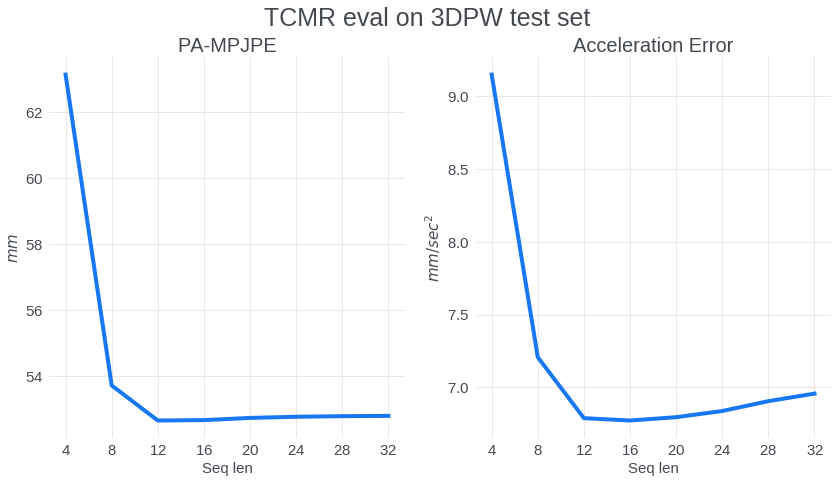

In [176]:
fig, ax = plt.subplots(1,2,figsize=(14,7))
ax[0].plot(list(mpjpe_pa_arr.keys()), list(mpjpe_pa_arr.values()))
ax[1].plot(list(accel_err_arr.keys()), list(accel_err_arr.values()))

for axis in ax: axis.set_xlabel("Seq len")
for axis in ax: axis.set_xticks(seqlens)
ax[0].set_ylabel(r"$mm$")
ax[1].set_ylabel(r"$mm/sec^2$")

ax[0].set_title("PA-MPJPE", fontsize=20)
ax[1].set_title("Acceleration Error", fontsize=20)

fig.suptitle("TCMR eval on 3DPW test set", fontsize=25)
fig.patch.set_facecolor("white")